<AxesSubplot:xlabel='date'>

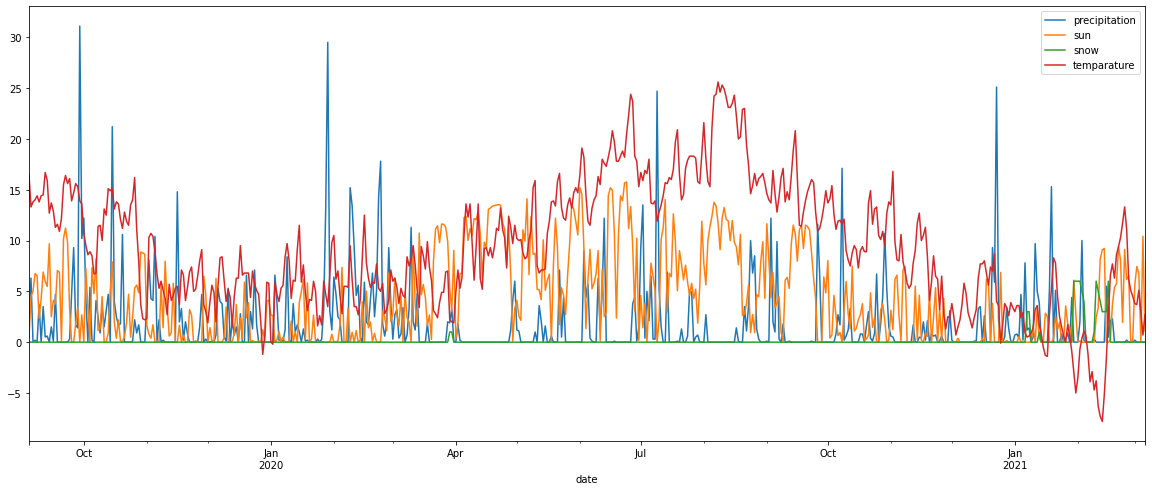

In [144]:
import pandas as pd

weather_df = pd.read_csv("./data/klarchiv_01975_daily_akt/produkt_klima_tag_20190904_20210306_01975.txt", 
                             delimiter=";", skipinitialspace=True, usecols=['TMK', 'RSK', 'SHK_TAG', 'SDK',  'MESS_DATUM'],
                        parse_dates=['MESS_DATUM'])
weather_df.rename(columns={'MESS_DATUM': 'date', 'RSK': 'precipitation', 'SDK': 'sun', 'SHK_TAG': 'snow', 'TMK': 'temparature'}, inplace=True)
weather_df.set_index('date',  inplace=True)

weather_df.plot(figsize=(20,8))

<AxesSubplot:xlabel='date'>

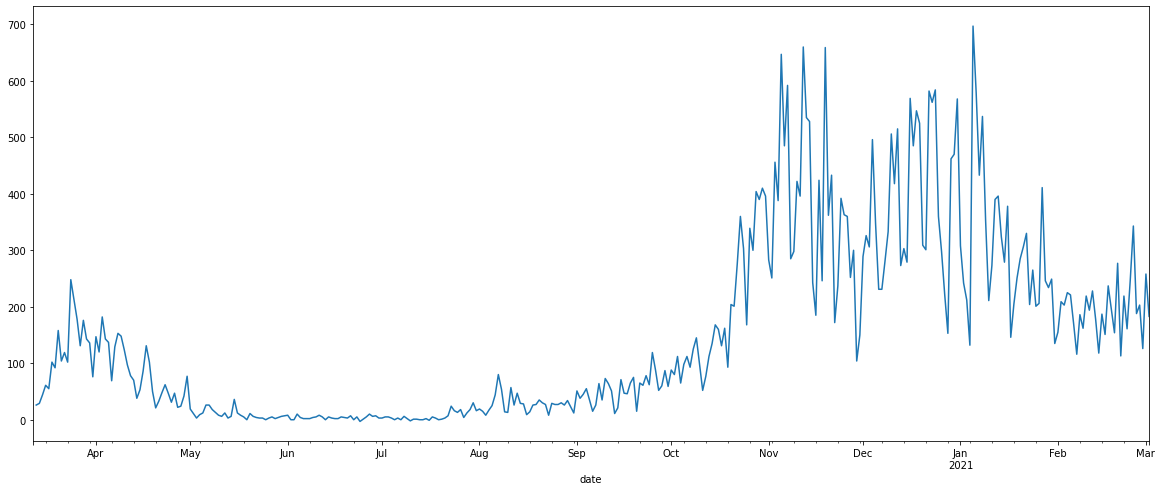

In [141]:
#pd.set_option('display.max_rows', 100)

incidence_df = pd.read_excel("./data/d-inzidenz-zum-download-service.xlsx", usecols=['Unnamed: 1', 'Unnamed: 2'])
incidence_df.drop([0], inplace=True)
incidence_df.rename(columns={'Unnamed: 1': 'date', 'Unnamed: 2': 'cumulative_incidence'}, inplace=True)

incidence_df.loc[[316], 'date'] = '2021-01-21 00:00:00'  # messed up date in row 316
incidence_df['date'] = pd.to_datetime(incidence_df['date'])
incidence_df.set_index('date',  inplace=True)
incidence_df

incidence_df['cumulative_incidence'].diff().plot(figsize=(20,8))

<AxesSubplot:xlabel='date'>

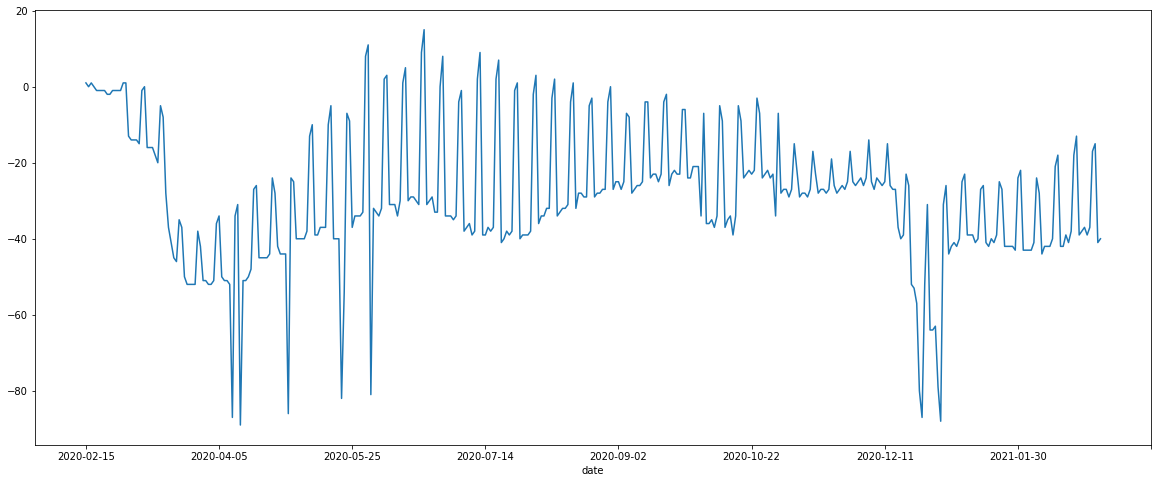

In [136]:
cols = ['sub_region_1', 'date', 'retail_and_recreation_percent_change_from_baseline', 
        'grocery_and_pharmacy_percent_change_from_baseline',
        'parks_percent_change_from_baseline',
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline',
        'residential_percent_change_from_baseline']

mobility_df = pd.read_csv("./data/2020_DE_Region_Mobility_Report.csv", usecols=cols)
mobility_df = mobility_df.loc[mobility_df['sub_region_1'] == "Hamburg"]
mobility_df.reset_index(drop=True, inplace=True)
mobility_df.set_index('date',  inplace=True)


mobility_df['workplaces_percent_change_from_baseline'].plot(figsize=(20,8))